# Introduction to Deep Learning

In [252]:
import numpy as np
import matplotlib.pyplot as plt
import h5py

You are given a dataset containing:
- a training set of m_train images labeled as cat (y=1) or non-cat (y=0)
- a test set of m_test images labeled as cat or non-cat
- each image is of shape `(num_px, num_px, 3)` where 3 is for the 3 channels (RGB). Thus, each image is square (height = num_px) and (width = num_px).

You will build a simple image-recognition algorithm that can correctly classify pictures as cat or non-cat.

Let's get more familiar with the dataset. Load the data by running the following code.

In [253]:
def loadDataset():
    trainDataset = h5py.File("datasets/train_catvnoncat.h5", "r")
    trainDatasetX = np.array(trainDataset["train_set_x"][:])
    trainDatasetY = np.array(trainDataset["train_set_y"][:])
    
    testDataset = h5py.File("datasets/test_catvnoncat.h5")
    testDatasetX = np.array(testDataset["test_set_x"][:])
    testDatasetY = np.array(testDataset["test_set_y"][:])

    classes = np.array(trainDataset["list_classes"][:])

    trainDatasetY = trainDatasetY.reshape((1, trainDatasetY.shape[0]))
    testDatasetY = testDatasetY.reshape((1, testDatasetY.shape[0]))
    return trainDatasetX, trainDatasetY, testDatasetX, testDatasetY, classes

trainDatasetX, trainDatasetY, testDatasetX, testDatasetY, classes = loadDataset()
print(trainDatasetX.shape, trainDatasetY.shape)
print(testDatasetX.shape, testDatasetY.shape)

(209, 64, 64, 3) (1, 209)
(50, 64, 64, 3) (1, 50)


Each line of your train_set_x_orig and test_set_x_orig is an array representing an image. You can visualize an example by running the following code. Feel free also to change the `index` value and re-run to see other images. 

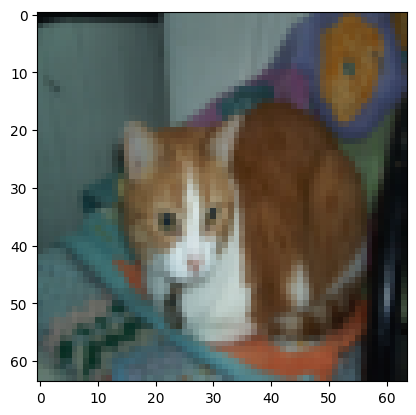

y = 1, it's a 'cat' picture.


In [254]:
index = 134
plt.imshow(trainDatasetX[index])
plt.show()
print ("y = " + str(trainDatasetY[0, index]) + ", it's a '" + classes[np.squeeze(trainDatasetY[:, index])].decode("utf-8") +  "' picture.")

Find the values for:
- m_train (number of training examples)
- m_test (number of test examples)
- num_px (= height = width of a training image)  
Remember that `train_set_x_orig` is a numpy-array of shape (m_train, num_px, num_px, 3). For instance, you can access `m_train` by writing `train_set_x_orig.shape[0]`.

In [255]:
m_train = trainDatasetX.shape[0]
m_test = testDatasetX.shape[0]
num_px = trainDatasetX.shape[1]

# let's print some usefull imformation
print("Number of training examples: ", m_train)
print("Number of testing examples: ", m_test)
print("Height of image: ", num_px, "px")
print("Shape of image: ", trainDatasetX[0].shape)
print("Shape of training dataset X: ", trainDatasetX.shape)
print("Shape of training dataset Y: ", trainDatasetY.shape)

Number of training examples:  209
Number of testing examples:  50
Height of image:  64 px
Shape of image:  (64, 64, 3)
Shape of training dataset X:  (209, 64, 64, 3)
Shape of training dataset Y:  (1, 209)


For convenience, you should now reshape images of shape (num_px, num_px, 3) in a numpy-array of shape (num_px $*$ num_px $*$ 3, 1). After this, our training (and test) dataset is a numpy-array where each column represents a flattened image. There should be m_train (respectively m_test) columns.

A trick when you want to flatten a matrix X of shape (a,b,c,d) to a matrix X_flatten of shape (b * c * d, a) is to use: 
```
X_flatten = X.reshape(X.shape[0], -1).T
```

In [256]:
XTrainFlatten = trainDatasetX.reshape(trainDatasetX.shape[0],-1).T
XTestFlatten = testDatasetX.reshape(testDatasetX.shape[0],-1).T
print("Shape of XTrainFlatten: ", XTrainFlatten.shape)
print("Shape of XTestFlatten: ", XTestFlatten.shape)

Shape of XTrainFlatten:  (12288, 209)
Shape of XTestFlatten:  (12288, 50)


To represent color images, the red, green and blue channels (RGB) must be specified for each pixel, and so the pixel value is actually a vector of three numbers ranging from 0 to 255.

One common preprocessing step in machine learning is to center and standardize your dataset, meaning that you substract the mean of the whole numpy array from each example, and then divide each example by the standard deviation of the whole numpy array. But for picture datasets, it is simpler and more convenient and works almost as well to just divide every row of the dataset by 255 (the maximum value of a pixel channel).

In [257]:
XTrainFlatten = XTrainFlatten / 255
XTestFlatten = XTestFlatten / 255

Sigmoid Function

In [258]:
def sigmoid(z):
    return 1/(1+np.exp(-z))

Initialize Parameters

In [259]:
def initializeParameters(dim):
    w = np.zeros((dim, 1))
    b = 0
    return w, b

## Logistic Regression 
#### Forward Propagation
$$
Z = W^T X + b  \\
A = sigmoid(X) \\
$$
#### Calculate Cost
$$
J = -\frac{1}{m}\sum_{i=1}^{m}y^{(i)}\log(a^{(i)})+(1-y^{(i)})\log(1-a^{(i)})
$$
#### Backward Propagation
$$ \partial W = \frac{\partial J}{\partial W} = \frac{1}{m}X(A-Y)^T\tag{7}$$
$$ \partial b = \frac{\partial J}{\partial b} = \frac{1}{m} \sum_{i=1}^m (a^{(i)}-y^{(i)})\tag{8}$$
#### Parameter Updation
$$ W = W - \alpha \text{ } \partial W $$
$$ b = b - \alpha \text{ } \partial b $$

Let's implements forward propagation, cost calculation and backward propagation in one function

In [260]:
def propagate(w, b, X, Y):
    m = X.shape[1]

    #forward prop
    Z = np.dot(w.T, X)+b
    A = sigmoid(Z)

    #cost calculation
    cost = (-1/m)*(np.sum(Y*np.log(A)+(1-Y)*np.log(1-A)))
    
    #backward prop
    db = (1/m)*np.sum(A-Y)
    dw = (1/m)*np.dot(X, ((A-Y).T))
    grad = {"dw": dw,
            "db": db}
    
    return grad, cost

Implement gradient decent for training our weights

In [261]:
def train_model(X, Y, numIterations, learningRate, printCost = False):
    nx = X.shape[0]
    m = X.shape[1]
    w, b = initializeParameters(nx)
    costs = []

    for i in range(numIterations):
        #forward propagation, cost calculation and backward propagation
        grad, cost = propagate(w, b, X, Y)
        costs.append(cost)
        #update weights
        w -= learningRate*grad["dw"]
        b -= learningRate*grad["db"]

        if(printCost and i%100==0):
            print(f"Cost after {i} iterations: {cost}")
    
    params = {"w": w,
              "b": b}
    
    return params, costs

In [310]:
params, costs = train_model(XTrainFlatten, trainDatasetY, numIterations = 10000, learningRate = 0.008, printCost = True)

Cost after 0 iterations: 0.6931471805599453
Cost after 100 iterations: 0.50402066728841
Cost after 200 iterations: 0.6216749014636461
Cost after 300 iterations: 0.5389833486161065
Cost after 400 iterations: 0.4378837385019491
Cost after 500 iterations: 0.3322113233683852
Cost after 600 iterations: 0.2362005705752742
Cost after 700 iterations: 0.1836529752248794
Cost after 800 iterations: 0.16848465645427102
Cost after 900 iterations: 0.1568516744134947
Cost after 1000 iterations: 0.14680664440604782
Cost after 1100 iterations: 0.13797061897414353
Cost after 1200 iterations: 0.13011258680750432
Cost after 1300 iterations: 0.12307038626759956
Cost after 1400 iterations: 0.11672101852104064
Cost after 1500 iterations: 0.11096706076152171
Cost after 1600 iterations: 0.10572932370184207
Cost after 1700 iterations: 0.1009423418072529
Cost after 1800 iterations: 0.09655133800379546
Cost after 1900 iterations: 0.09251004952961168
Cost after 2000 iterations: 0.08877910431297134
Cost after 2100 

Let's see how cost decrease with iterations

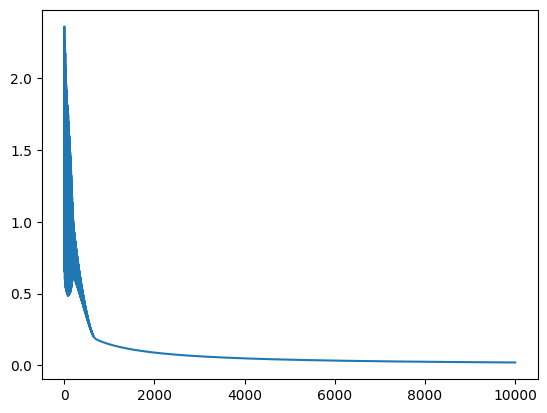

In [311]:
plt.plot(costs)
plt.show()

Let's Predict out model's output on train and test images and and see how our model performed

In [312]:
def predict(params, X, Y):
    w = params["w"]
    b = params["b"]
    Z = w.T.dot(X) + b
    A = sigmoid(Z)
    Y_Prediction = (A > 0.5) * 1.0
    return Y_Prediction

#checking accuracy
trainPrediction = predict(params, XTrainFlatten, trainDatasetY)
testPrediction = predict(params, XTestFlatten, testDatasetY)
print(f"train accuracy: {100-np.mean(np.abs(trainPrediction-trainDatasetY))*100}")
print(f"test accuracy: {100-np.mean(np.abs(testPrediction-testDatasetY))*100}")

train accuracy: 100.0
test accuracy: 72.0
